Coexisting densities: phi1 = -1.0579, phi2 = 0.9298


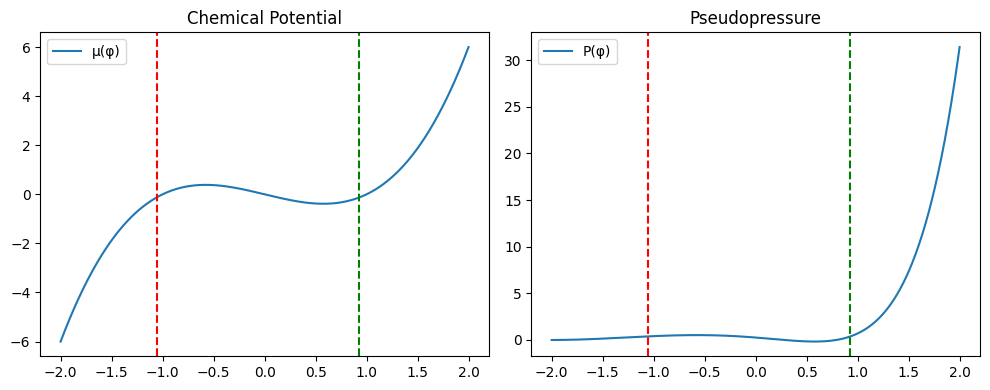

In [34]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Model parameters
A = -1
B = 1
K = 1
zeta = -4   # Try a value like 1.0 or 2.0
lmbda = -2.5   # Lambda spelled out

alpha = (zeta - 2 * lmbda) / K

# Define phi grid
phi = np.linspace(-2, 2, 1000)

# Step 1: Pseudodensity psi(phi)
dpsi_dphi = np.exp(alpha * phi)
psi = cumulative_trapezoid(dpsi_dphi, phi, initial=0)

# Step 2: Pseudopotential g(phi)
f_prime = A * phi + B * phi**3
dg_dphi = f_prime * dpsi_dphi
g = cumulative_trapezoid(dg_dphi, phi, initial=0)

# Interpolators for numerical functions
from scipy.interpolate import interp1d
mu_interp = interp1d(phi, f_prime, kind='cubic')
psi_interp = interp1d(phi, psi, kind='cubic')
g_interp = interp1d(phi, g, kind='cubic')
P_interp = lambda x: psi_interp(x) * mu_interp(x) - g_interp(x)

# Step 3: Solve for phi1 and phi2
def coexistence_system(vars):
    phi1, phi2 = vars
    return [
        mu_interp(phi1) - mu_interp(phi2),
        P_interp(phi1) - P_interp(phi2)
    ]

phi_guess = [-1.0, 1.0]
phi1, phi2 = fsolve(coexistence_system, phi_guess)

print(f"Coexisting densities: phi1 = {phi1:.4f}, phi2 = {phi2:.4f}")

# Optional: Plot chemical potential and pseudopressure
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(phi, f_prime, label='μ(φ)')
plt.axvline(phi1, color='red', linestyle='--')
plt.axvline(phi2, color='green', linestyle='--')
plt.title('Chemical Potential')
plt.legend()

plt.subplot(1, 2, 2)
P_vals = P_interp(phi)
plt.plot(phi, P_vals, label='P(φ)')
plt.axvline(phi1, color='red', linestyle='--')
plt.axvline(phi2, color='green', linestyle='--')
plt.title('Pseudopressure')
plt.legend()

plt.tight_layout()
plt.show()


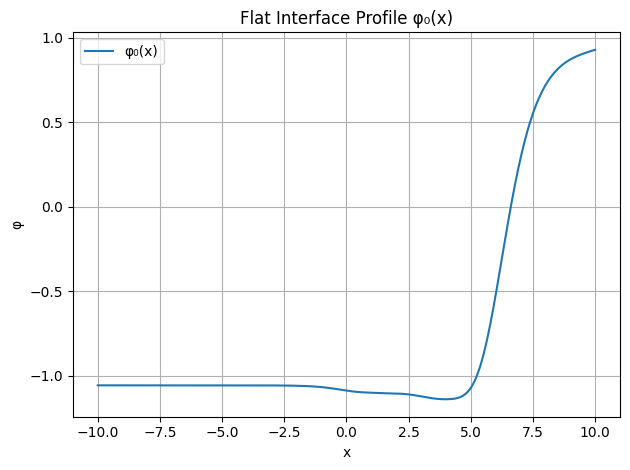

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Use your binodal values from Appendix B
phi1 = phi1
phi2 = phi2

# Model parameters
A = -1
B = 1
K = 1
mu = A * phi1 + B * phi1**3  # You can also average mu(phi1) and mu(phi2)

# Define the ODE: d²φ/dx² = (df/dφ - μ) / K
def ode(x, y):
    phi = y[0]
    dphi_dx = y[1]
    df_dphi = A * phi + B * phi**3
    d2phi_dx2 = (df_dphi - mu) / K
    return np.vstack([dphi_dx, d2phi_dx2])

# Boundary conditions: phi at -L and +L
def bc(ya, yb):
    return np.array([ya[0] - phi1, yb[0] - phi2])

# Spatial domain
L = 10
x = np.linspace(-L, L, 500)
# Initial guess: tanh-like profile
phi_guess = phi1 + (phi2 - phi1) * (np.tanh(x) + 1)/2
y_guess = np.vstack([phi_guess, np.gradient(phi_guess, x)])

# Solve BVP
sol = solve_bvp(ode, bc, x, y_guess)

# Plot result
x_plot = sol.x
phi0 = sol.y[0]
dphi_dx = sol.y[1]

plt.plot(x_plot, phi0, label='φ₀(x)')
plt.xlabel("x")
plt.ylabel("φ")
plt.title("Flat Interface Profile φ₀(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
from scipy.integrate import simpson

# Extract profile and derivative from the BVP solution
x_vals = sol.x
phi_vals = sol.y[0]
dphi_dx_vals = sol.y[1]

# Compute S0 and S1
S0 = simpson(dphi_dx_vals**2, x_vals)
S1 = simpson(phi_vals * dphi_dx_vals**2, x_vals)



denom = zeta - 2 * lmbda
if np.abs(denom) < 1e-6:
    raise ValueError("Denominator ζ − 2λ is too small, pseudotension is ill-defined.")

sigma = K / denom * (zeta * S0 - 2 * lmbda * S1)

print(f"S₀ = {S0:.6f}")
print(f"S₁ = {S1:.6f}")
print(f"Pseudotension σ = {sigma:.6f}")


S₀ = 1.239141
S₁ = -0.237316
Pseudotension σ = -6.143144


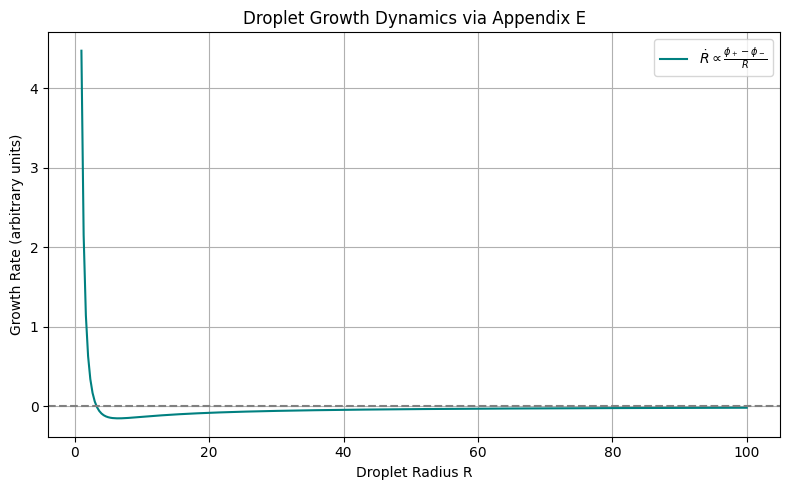

In [39]:
import numpy as np
import matplotlib.pyplot as plt
sigma = sigma # Your computed pseudotension

# Second derivatives of f at binodals
fpp_phi1 = A + 3 * B * phi1**2
fpp_phi2 = A + 3 * B * phi2**2

# Compute curvature correction coefficients
a_plus = -sigma / fpp_phi1
a_minus = sigma / fpp_phi2

# Radii range
R_vals = np.linspace(1, 100, 300)
phi_plus = phi1 + a_plus / R_vals
phi_minus = phi2 + a_minus / R_vals

# Growth rate (up to constant)
dR_dt = (phi_plus - phi_minus) / R_vals

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(R_vals, dR_dt, label=r"$\dot{R} \propto \frac{\phi_+ - \phi_-}{R}$", color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Droplet Radius R")
plt.ylabel("Growth Rate (arbitrary units)")
plt.title("Droplet Growth Dynamics via Appendix E")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import cumulative_trapezoid, simpson, solve_bvp
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Fixed model parameters
A, B, K = -1, 1, 1

# Parameter grids
zeta_vals   = np.linspace(-4, 4, 50)
lambda_vals = np.linspace(-2, 2, 50)
sigma_grid  = np.full((len(zeta_vals), len(lambda_vals)), np.nan)

# phi axis for constructing pseudodensity & pseudopressure
phi = np.linspace(-2, 2, 1000)
f_prime = A*phi + B*phi**3

for i, zeta in enumerate(zeta_vals):
    for j, lmbda in enumerate(lambda_vals):
        alpha = (zeta - 2*lmbda) / K

        # 1) pseudodensity ψ(φ)
        dpsi_dphi = np.exp(alpha * phi)
        psi = cumulative_trapezoid(dpsi_dphi, phi, initial=0)

        # 2) pseudopotential g(φ)
        dg_dphi = f_prime * dpsi_dphi
        g = cumulative_trapezoid(dg_dphi, phi, initial=0)

        # interpolators
        mu_interp  = interp1d(phi, f_prime,     kind='cubic', bounds_error=False, fill_value=np.nan)
        psi_interp = interp1d(phi, psi,         kind='cubic', bounds_error=False, fill_value=np.nan)
        g_interp   = interp1d(phi, g,           kind='cubic', bounds_error=False, fill_value=np.nan)
        P = lambda x: psi_interp(x)*mu_interp(x) - g_interp(x)

        # 3) solve for φ1, φ2 via equal-μ and equal-P
        def coexist(vars):
            φ1, φ2 = vars
            return [
                mu_interp(φ1) - mu_interp(φ2),
                P(φ1) - P(φ2)
            ]
        try:
            φ1, φ2 = fsolve(coexist, [-1.0, 1.0])
        except Exception:
            continue

        # check ordering
        if not (phi.min() < φ1 < φ2 < phi.max()):
            continue

        # chemical potential at bulk
        mu0 = A*φ1 + B*φ1**3

        # 4) BVP for flat interface profile
        def ode(x, y):
            ϕ, dϕ = y
            return np.vstack([dϕ, (A*ϕ + B*ϕ**3 - mu0)/K])

        def bc(ya, yb):
            return np.array([ya[0] - φ1, yb[0] - φ2])

        L = 10
        x_grid = np.linspace(-L, L, 500)
        init_ϕ = φ1 + (φ2 - φ1)*(np.tanh(x_grid) + 1)/2
        y_guess = np.vstack([init_ϕ, np.gradient(init_ϕ, x_grid)])

        try:
            sol = solve_bvp(ode, bc, x_grid, y_guess)
        except Exception:
            continue

        x_vals      = sol.x
        ϕ_vals      = sol.y[0]
        dϕ_dx_vals  = sol.y[1]

        # 5) integrals S0, S1
        S0 = simpson(dϕ_dx_vals**2, x_vals)
        S1 = simpson(ϕ_vals * dϕ_dx_vals**2, x_vals)

        denom = zeta - 2*lmbda
        if np.abs(denom) < 1e-6:
            sigma = np.nan
        else:
            sigma = K/denom * (zeta*S0 - 2*lmbda*S1)

        sigma_grid[i, j] = sigma

# Plot σ(ζ, λ)
Z, L = np.meshgrid(zeta_vals, lambda_vals, indexing='ij')
plt.figure(figsize=(7,5))
cs = plt.contourf(Z, L, sigma_grid, levels=30)
plt.colorbar(cs, label='σ pseudotension')
plt.xlabel('ζ')
plt.ylabel('λ')
plt.title('Pseudotension σ over (ζ, λ)')
plt.tight_layout()
plt.show()


C:\Users\anuhe\AppData\Local\Temp\ipykernel_32332\2595242922.py:45: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  φ1, φ2 = fsolve(coexist, [-1.0, 1.0])
C:\Users\anuhe\AppData\Local\Temp\ipykernel_32332\2595242922.py:45: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  φ1, φ2 = fsolve(coexist, [-1.0, 1.0])
